In [1]:
import numpy as np
from scipy.stats import rayleigh
from scipy.special import digamma,erf
import scipy.io as sio
import pandas as pd
import matplotlib.pylab as plt
import copy

In [2]:
def parse_mat(data):
    dataSeqs= data['Seqs']  
    mdtype = dataSeqs.dtype
    seqs = {n: dataSeqs[n].flatten() for n in mdtype.names}
    if 'Stats' in data:
        dataStats = data['Stats']  
        mdtype = dataSeqs.dtype  
        stats = {n: dataSeqs[n].flatten() for n in mdtype.names}
        
        return seqs,stats
    return seqs, None

In [3]:
class Model:
    def __init__(self,seqs,K):
            self.N = len(seqs['Time'])
            D= np.zeros(self.N)
            sigma = np.zeros(self.N)
            Tmax = np.zeros(self.N)
            self.K = K
            for i in range(self.N):
                D[i] = np.max(seqs['Mark'][i])
                # actual sigma and Tmax
                sigma[i] = np.nan_to_num((4*(np.std(seqs['Time'][i].flatten(), ddof=1)**5) / (3* len(seqs['Time'][i].flatten())))**0.2)
                Tmax[i] = seqs['Time'][i][-1][0] + np.spacing(1)
                
                #this sigma and Tmax is for syn_data
#                 sigma[i] = np.nan_to_num((4*(np.std(seqs['Time'][i], ddof=1)**5) / (3* len(seqs['Time'][i][0])))**0.2)
#                 Tmax[i] = np.max(seqs['Time'][i]) + np.spacing(1)
#                 print('Tmax[',i,']=',Tmax[i])
#                 print('sigma[',i,']=',sigma[i])
            self.D = np.int(np.max(D))
            Tmax = np.mean(Tmax)
            self.w = np.mean(sigma)
#             print(self.w)
#             print(Tmax)
            self.landmark = self.w* range(np.int(np.ceil(Tmax/self.w))+1) # +1 added
#             self.alpha = np.ones(K)   # why is this np.ones(K) ??
            self.alpha = 1
            M = len(self.landmark)
            self.beta = np.ones((self.D,M,self.K,self.D)) / (M*(self.D**2))
            self.b = np.ones((self.D,K))/self.D
            
            ## for testing purpose
            l1 = np.zeros(int(self.N/2))
            l2 = np.ones(int(self.N-int(self.N/2)))

            label = np.append(l1, l2)

#             label = np.round(K * np.random.rand(self.N))
            self.r = np.zeros((self.N,K))
            for k in range(K):
                self.r[label==k,k] = 1
            self.kernel = "gauss"
class Alg:
    def __init__ (self, outer = 8,rho = 0.1,inner = 5,thres = 1e-5,Tmax = []):
        self.outer = outer
        self.rho = rho
        self.inner = inner
        self.thres = thres
        self.Tmax = Tmax

In [4]:
def kernel_int(dt,model):
    distance = np.tile(dt.flatten(),(len(model.landmark),1))
    landmark = np.tile(model.landmark.conj(),(len(dt.flatten()),1)).T
    distance = distance.astype(np.float64)
    landmark = landmark.astype(np.float64)
    distance -= landmark
    G = 0
    if model.kernel == 'gauss':
        G = 0.5 *(erf(distance/((np.sqrt(2))*model.w))
                  + erf(landmark/((np.sqrt(2))*model.w)))
    elif model.kernel == 'exp':
        G = 1 - np.exp(-model.w * (distance-landmark));
        G[G<0] = 0
    return G

In [5]:
def kernel(dt,model):
    distance = np.tile(dt.flatten(),(len(model.landmark),1))
    landmark = np.tile(model.landmark.conj(),(len(dt.flatten()),1)).T
    distance = distance.astype(np.float64)
    landmark = landmark.astype(np.float64)
    distance -= landmark
    g = 0
    if model.kernel == 'gauss':
        g = np.exp(-(distance**2)/(2*(model.w**2)))/(np.sqrt(2*np.pi)*model.w)
    elif model.kernel == 'exp':
        g = model.w * np.exp(-model.w * distance)
        g[g>1] = 0
    return g

In [6]:
def E_log_pi(alpha):
    return digamma(alpha)  - digamma(np.sum(alpha))

In [7]:
def Expectation_DMHP(seqs,model,alg):
    Nk = np.sum(model.r,0)
    alpha = model.alpha + Nk
    Elogpi = E_log_pi(alpha)
#     print(LL)
    EX = np.zeros((len(seqs['Time']),model.K))
    for c in range(len(seqs['Time'])):
        time = seqs['Time'][c].flatten()
        event = seqs['Mark'][c].flatten()
        Tstart = seqs['Start'][c].flatten()
        if not alg.Tmax:
            Tstop = seqs['Stop'][c].flatten()
        else:
            Tstop = alg.Tmax
            indt = time < alg.Tmax
            time = time[indt]
            event = event[indt]
        N = len(time)
#         print(Tstop-time)
        G = kernel_int(Tstop-time,model)
#         print(np.sum(G))
        LL = Elogpi
        for i in range(N):
            ui = event[i]
            ti = time[i]
        
            E_lambda_i = (np.sqrt(np.pi/2) * model.b[ui-1,:]).flatten() + np.spacing(1)
            V_lambda_i = ((2 - np.pi/2) * (model.b[ui-1,:]**2)).flatten()
#             print(np.sum(E_lambda_i))
#             print(np.sum(V_lambda_i))
            if i > 0:
                uj = event[0:i].flatten()
                tj = time[0:i].flatten()
#                 print(ti-tj)
                gij = kernel(ti-tj,model)
                auiuj = model.beta[uj-1,:,:,ui-1]
                tiled = np.tile(gij,(1,1,1))
                tiled = np.tile(tiled.T,(1,1,model.K))
                pij = np.multiply(tiled,auiuj)
#                 print(pij.shape)
                tmp = np.sum(pij,axis=(0,1))
                E_lambda_i += tmp.conj().T
                tmp = np.sum(pij**2,axis=(0,1))
#                 print(tmp.shape)
#                 print(tmp)
                V_lambda_i += tmp.conj().T
            LL = LL + np.log(E_lambda_i) - (V_lambda_i/ (2*(E_lambda_i**2)))
#             print(LL)
        
#         print(np.sum(model.b, 0))
        LL -= (Tstop-Tstart).flatten() * (np.sqrt(np.pi/2) * np.sum(model.b, 0))
#         print(LL)  #error
        temp = np.tile(G,(model.K,1,1)).T
        temp2 = np.multiply(temp,np.sum(model.beta[event-1,:,:,:],axis = 3))
        tmp = np.sum(temp2,(0,1))
        LL -= tmp
#         print(LL)  # error
        XX = (LL - np.max(LL))
        EX[c,:] = (np.exp(XX) / np.sum(np.exp(XX)))
    
    model.r = EX

In [8]:
def Maximization_DMHP (seqs,model,alg):
    EX = model.r
    A = model.beta
    mu = np.sqrt(np.pi/2)*model.b
    
#     print('A: ', A.shape)

    for inn in range(alg.inner):
        temp1 = A / model.beta
        temp1[np.isnan(temp1)]  = 0
        temp1[np.isinf(temp1)]  = 0
    
        temp2 = (mu**2) / (2*(model.b**2))
        temp2[np.isnan(temp2)]  = 0
        temp2[np.isinf(temp2)]  = 0
    
        temp3 = np.log(mu)  
        temp3[np.isnan(temp3)]  = 0
        temp3[np.isinf(temp3)]  = 0
        
#         print('tmp1=',np.sum(temp1),', tmp2=',np.sum(temp2),', tmp3=',np.sum(temp3))
        
        NLL = np.sum(temp1) + np.sum(temp2) - np.sum(temp3)  # minus.. temp3
#         print('NLL:', NLL)
    
        MuA = 1 / (model.b**2)
        MuA[np.isinf(MuA)]  = 0
        MuB = 0
        MuC = - np.ones(model.b.shape)
    
        AB = np.zeros(A.shape)
        AA =  1 / (model.beta)
        AA[np.isinf(AA)] = 0
        
    
        for c in range(len(seqs['Time'])):
        
            time = seqs['Time'][c].flatten()
            event = seqs['Mark'][c].flatten()
            Tstart = seqs['Start'][c].flatten()
        
            if not alg.Tmax:
                Tstop = seqs['Stop'][c].flatten()
            else:
                Tstop = alg.Tmax
                indt = time < alg.Tmax
                time = time[indt]
                event = event[indt]
            N = len(time)
            G = kernel_int(Tstop-time,model)
#             print(Tstop-time)
#             print('G: ')
#             print(G)
#             print('G end')
        
            TMPAA = np.zeros(A.shape)
            TMPAB = np.zeros(A.shape)
            TMPMuC = np.zeros(mu.shape)
            LL = 0
            for i in range(N):
#            
                ui = event[i]
                ti = time[i]
            
                tmp = np.tile(G[:,i],(model.D,model.K,1)).T
            
                TMPAA[ui-1,:,:,:] = TMPAA[ui-1,:,:,:] + tmp ## look at here 
            
                lambdai = mu[ui-1,:] + np.spacing(1)  ## added spacing
                pii = lambdai;
            
                if i > 0:
                    uj = event[0:i].flatten()
                    tj = time[0:i].flatten()
#                     print(ti-tj)
                    gij = kernel(ti-tj,model)
#                     print('gij')
#                     print(gij)
                    auiuj = A[uj-1,:,:,ui-1]  ## A instead of model.beta and ui
                    tiled = np.tile(gij,(1,1,1))
                    tiled = np.tile(tiled.T,(1,1,model.K))
                    pij = np.multiply(tiled,auiuj)
#                     print(np.sum(pij, axis=1))
#                     print(pij.shape)
                
                    tmp = np.sum(pij,(0,1))
#                     print(np.sum(tmp))
                    lambdai += tmp.conj().T  ## lambdai += tmp 
#                     print(np.sum(lambdai))                
                    tmp = np.tile(lambdai,(pij.shape[0],pij.shape[1],1))
                    pij /= tmp
                
                    for j in range(i):
                        uj = event[j]
                        TMPAB[uj-1,:,:,ui-1] -= pij[j,:,:]
                    
                LL += np.log(lambdai) 
#                 print(LL)
            
                pii /= lambdai
                TMPMuC[ui-1,:] -= pii
            
#             print('LL:')
#             print(np.sum(LL))
            LL-= (Tstop - Tstart) * (np.sum(mu, axis=0))
#             print(mu.shape)
#             print(Tstop - Tstart)
#             print(np.sum(mu))
#             print((Tstop - Tstart) * (np.sum(mu, axis=0)))
#             print(np.sum(LL))
            temp = np.tile(G,(model.K,1,1)).T
            temp2 = np.multiply(temp,np.sum(A[event-1,:,:,:],axis = 3))
            tmp = np.sum(temp2,(0,1))
#             print(np.sum(tmp))
            LL -= tmp.conj().T ## changed to conj
#             print(np.sum(LL))
        
            MuB += (Tstop-Tstart) * EX[c,:]
        
            for k in range(model.K):
                AA[:,:,k,:] = AA[:,:,k,:] + (EX[c,k]*TMPAA[:,:,k,:]) 
                AB[:,:,k,:] = AB[:,:,k,:] + (EX[c,k]*TMPAB[:,:,k,:]) 
                MuC[:,k] = MuC[:,k] +  (EX[c,k]*TMPMuC[:,k]) 
#             NLL -= np.sum(EX[c,:]*LL)
#             print(np.sum(LL))
            NLL -= np.dot(EX[c,:],LL)
#             print(NLL)
        MuBB = np.tile(MuB,(model.D,1))
        mutmp = (-MuBB + np.sqrt((MuBB)**2 - 4*(MuA * MuC))) / (2*MuA)
        Atmp = -AB / AA
    
        Atmp[np.isnan(Atmp)] = 0
        mutmp[np.isnan(mutmp)] = 0
        Atmp[np.isinf(Atmp)] = 0
        mutmp[np.isinf(mutmp)] = 0
    
        Err = np.sum(np.abs(A - Atmp)) / np.sum(np.abs(A))  ## removed np.nan_to_num()
        print("Inner: ",inn, " NLL: ", NLL, " Err: ",Err)
        
        A = Atmp
        mu = mutmp
        
#         print(A)
#         print(np.sum(A))
    
        if Err < alg.thres or  inn == alg.inner:
            break
#     model.beta = A
#     model.b = np.sqrt(2/np.pi) * mu
    return NLL,A,mu
        

In [9]:
def plot_similarity(r):
    EstSimi = estimate_similarity(r)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(EstSimi,interpolation='nearest',cmap="binary_r")
    plt.colorbar()
    plt.show()

In [10]:
def Learn_DMHP(seqs,model,alg):
    NLL = np.zeros(alg.outer)
    for outer in range(alg.outer):
        NLL[outer],A,mu = Maximization_DMHP(seqs,model,alg)
        model.beta = A
        model.b = np.sqrt(2/np.pi) * mu
        Expectation_DMHP(seqs,model,alg)
        
        
        plot_similarity(model.r)
        print("Outer Iter: ",outer," NLL: ", NLL[outer])

In [11]:
# def Learn_DMHP(seqs,model,alg):
#     NLL = np.zeros(alg.outer)
#     for outer in range(alg.outer):
#         LL_1,A_1,mu_1= Maximization_DMHP(seqs,model,alg)
#         model_2 = copy.deepcopy(model) 
#         Expectation_DMHP(seqs,model_2,alg)
#         LL_2,A_2,mu_2= Maximization_DMHP(seqs,model_2,alg)
#         print("LL_1:", LL_1, " LL_2: ",LL_2)
#         if (LL_1 < LL_2):
#             model.beta = A_1
#             model.b = np.sqrt(2/np.pi) * mu_1
#             NLL[outer] = LL_1
#             print("LL_1 is smaller:", LL_1)
#         else:
#             model = copy.deepcopy(model_2)
#             model.beta = A_2
#             model.b = np.sqrt(2/np.pi) * mu_2
#             NLL[outer] = LL_2
#             print("LL_2 is smaller:", LL_2)
        
#         plot_similarity(model.r)
#         print("Outer Iter: ",outer," NLL: ", NLL[outer])

In [12]:
def cluster_purity(K, r, actual_label):
    W = np.argmax(r, axis=1)
    C = actual_label
    print('C:', C)
    print('W:', W)
    N = W.shape[0]
    purity = 0
    
    for k in range(K):
        index_k = np.where(W==k)
        print(index_k)
        print('C-W', C[index_k])
        C_k = C[index_k]
        count = []
        for k in range(K):
            count.append(np.sum(C_k==k))
            print(np.sum(C_k==k))

        purity+=np.max(count)
    
    return purity/N
        

In [13]:
def estimate_similarity(r):
    labels = np.argmax(r,axis = 1)
    EstSimi = np.zeros((len(labels),len(labels)))
    for i in range(len(labels)):
        for j in range(len(labels)):
            if(labels[i] == labels[j]):
                EstSimi[i,j] = 1
    return EstSimi

In [14]:
linkedInData = sio.loadmat('Data/LinkedinData.mat')
IPTVData = sio.loadmat('Data/IPTVData.mat')
synData = sio.loadmat('Data/syn_data.mat')
IPTVSeqs,IPTVStats = parse_mat(IPTVData)
linkedInSeqs,linedInStats = parse_mat(linkedInData)
synSeqs,synStats = parse_mat(synData)

Inner:  0  NLL:  17132.130154075618  Err:  0.8574590159029993
Inner:  1  NLL:  12486.780783559409  Err:  0.04773591983775849
Inner:  2  NLL:  12485.776036792771  Err:  0.04424600965941169
Inner:  3  NLL:  12484.94241285392  Err:  0.04153227370071948
Inner:  4  NLL:  12484.231672357118  Err:  0.039341769911045245


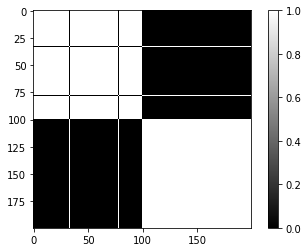

Outer Iter:  0  NLL:  12484.231672357118


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


Inner:  0  NLL:  12499.01136334316  Err:  0.10826740419617704
Inner:  1  NLL:  12494.419927292014  Err:  0.08339271005397453
Inner:  2  NLL:  12489.66939231753  Err:  0.06527015395270018
Inner:  3  NLL:  12486.884001835073  Err:  0.05408296189142912
Inner:  4  NLL:  12485.098508335885  Err:  0.046873563788556734


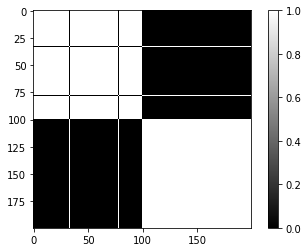

Outer Iter:  1  NLL:  12485.098508335885
Inner:  0  NLL:  12502.694758263115  Err:  0.06481651242585167
Inner:  1  NLL:  12486.027542048683  Err:  0.050301490308690786
Inner:  2  NLL:  12483.7120263676  Err:  0.04588115331207889
Inner:  3  NLL:  12482.52839814148  Err:  0.04371050031122304
Inner:  4  NLL:  12481.65125081511  Err:  0.04246627582641734


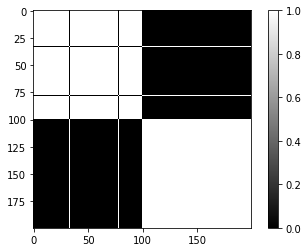

Outer Iter:  2  NLL:  12481.65125081511
Inner:  0  NLL:  12500.220781284776  Err:  0.05631006626657947
Inner:  1  NLL:  12480.18178808445  Err:  0.05333302319794655
Inner:  2  NLL:  12478.756741595746  Err:  0.051675948999196884
Inner:  3  NLL:  12477.67501307325  Err:  0.05052292986041455
Inner:  4  NLL:  12476.742273081902  Err:  0.04957709650996595


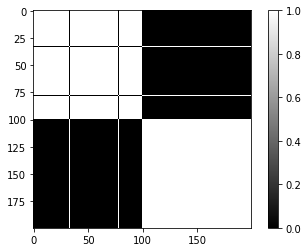

Outer Iter:  3  NLL:  12476.742273081902
Inner:  0  NLL:  12492.35262862034  Err:  0.06078677385244395
Inner:  1  NLL:  12468.920252731394  Err:  0.060402205737975743
Inner:  2  NLL:  12467.274573644167  Err:  0.05840147488151947
Inner:  3  NLL:  12465.997653519778  Err:  0.05666191534587717
Inner:  4  NLL:  12464.89283791296  Err:  0.05489121006046661


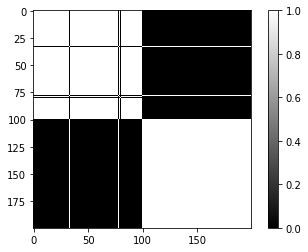

Outer Iter:  4  NLL:  12464.89283791296
Inner:  0  NLL:  12469.220931836227  Err:  0.05862493493380227
Inner:  1  NLL:  12450.665191297021  Err:  0.06273365669246307
Inner:  2  NLL:  12448.810672750595  Err:  0.059368677138475726
Inner:  3  NLL:  12447.280884971477  Err:  0.056123469703151664
Inner:  4  NLL:  12445.984726390572  Err:  0.05291324690286299


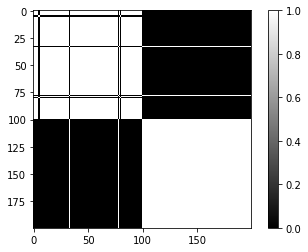

Outer Iter:  5  NLL:  12445.984726390572
Inner:  0  NLL:  12448.012313082381  Err:  0.05339894203425293
Inner:  1  NLL:  12436.309308032049  Err:  0.05579395079054143
Inner:  2  NLL:  12434.030766183967  Err:  0.05094916763394976
Inner:  3  NLL:  12432.515259418906  Err:  0.04663141253674085
Inner:  4  NLL:  12431.392330211329  Err:  0.042640911998110376


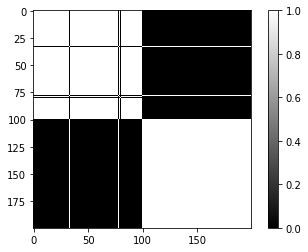

Outer Iter:  6  NLL:  12431.392330211329
Inner:  0  NLL:  12438.869372140078  Err:  0.044877859035774854
Inner:  1  NLL:  12427.547275236497  Err:  0.042791014964674565
Inner:  2  NLL:  12425.86231060917  Err:  0.038268346963175916
Inner:  3  NLL:  12424.873410668619  Err:  0.034292631321354905
Inner:  4  NLL:  12424.179651322029  Err:  0.030717555437459743


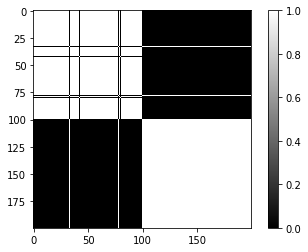

Outer Iter:  7  NLL:  12424.179651322029


In [15]:
model = Model(synSeqs,5)
alg = Alg()
Learn_DMHP(synSeqs,model,alg)

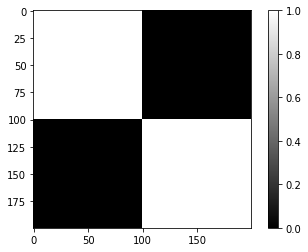

In [17]:
l1 = np.zeros(int(200/2))
l2 = np.ones(int(int(200/2)))
label = np.append(l1, l2)
r = np.zeros((200,5))
for k in range(5):
    r[label==k,k] = 1
# cluster_purity(5,model.r,label)
plot_similarity(r)